### Keijzer-6 Symbolic Regression Experiment
### Comparing Initialization Methods in Grammatical Evolution
### ###  Overview
# 
### This notebook compares three population initialization methods for Grammatical Evolution (GE):
# 
### | Method | Description |
### |--------|-------------|
### | **Random** | Baseline - random integer genomes |
### | **Sensible** | Ryan & Azad (2003) - grammar-aware, biases towards terminals at depth limit |
### | **PI-Grow** | Position Independent Grow - randomizes expansion order for uniform exploration | 
### ### Benchmark Problem: Keijzer-6
# 
### The **Keijzer-6** function is the harmonic series:
# 
### $$f(x) = \sum_{i=1}^{\lfloor x \rfloor} \frac{1}{i} = H_n$$
# 
### This is challenging because the harmonic series grows logarithmically: $H_n \approx \ln(n) + \gamma$
# 
# ---

##  Setup and Imports

In [1]:
# %%
# Core imports
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import entropy, mannwhitneyu
import warnings
import time
from datetime import datetime

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Imports complete!")
print(f"Experiment date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Imports complete!
Experiment date: 2026-01-18 18:24



###  Visual Configuration


In [2]:
# %%

plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Color palette - professional and color-blind friendly
COLORS = {
    'Random': '#E74C3C',      
    'Sensible': '#3498DB',      
    'PI-Grow': '#2ECC71',     
}

print("Visual configuration set!")
for method, color in COLORS.items():
    print(f"   {method}: {color}")

Visual configuration set!
   Random: #E74C3C
   Sensible: #3498DB
   PI-Grow: #2ECC71


### Keijzer-6 Benchmark Definition

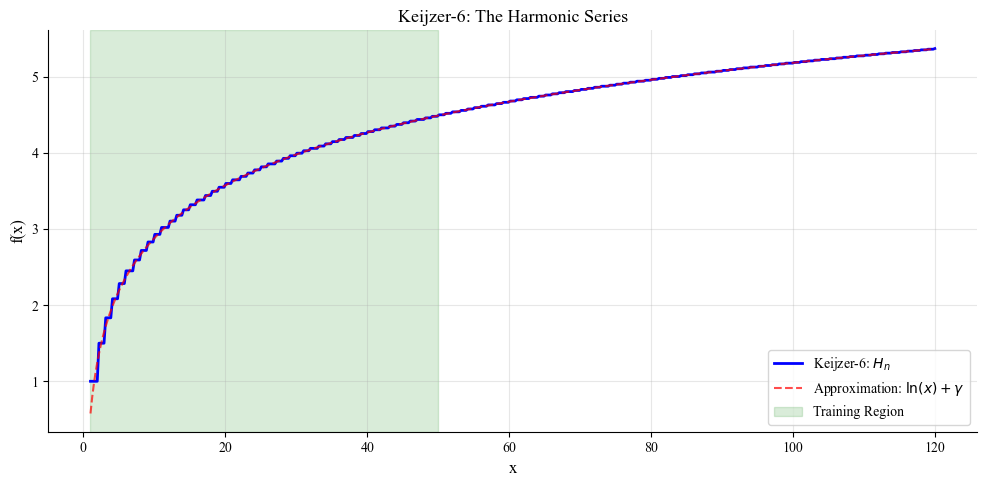

Keijzer-6 benchmark defined!


In [3]:

# 
# The Keijzer-6 function computes the **harmonic series** $H_n = \sum_{i=1}^{n} \frac{1}{i}$
# 
# - **Training range:** $x \in [1, 50]$
# - **Test range:** $x \in [1, 120]$ (includes extrapolation)

# %%
def keijzer_6(x):
    """
    Keijzer-6: f(x) = sum(1/i) for i=1 to floor(x)
    
    This is the harmonic series H_n, which grows as ln(n) + γ
    where γ ≈ 0.5772 is the Euler-Mascheroni constant.
    """
    return np.array([sum(1.0/i for i in range(1, int(xi)+1)) for xi in x])


def generate_k6_dataset():
    """Generate training and test datasets for Keijzer-6"""
    # Training: 50 evenly-spaced points in [1, 50]
    X_train = np.linspace(1, 50, 50).reshape(-1, 1)
    y_train = keijzer_6(X_train.flatten())
    
    # Test: 120 points in [1, 120] - includes extrapolation beyond training
    X_test = np.linspace(1, 120, 120).reshape(-1, 1)
    y_test = keijzer_6(X_test.flatten())
    
    return X_train, y_train, X_test, y_test


# Quick visualization of Keijzer-6
x_demo = np.linspace(1, 120, 500)
y_demo = keijzer_6(x_demo)

plt.figure(figsize=(10, 5))
plt.plot(x_demo, y_demo, 'b-', linewidth=2, label='Keijzer-6: $H_n$')
plt.plot(x_demo, np.log(x_demo) + 0.5772, 'r--', linewidth=1.5, 
         label='Approximation: $\ln(x) + \gamma$', alpha=0.7)
plt.axvspan(1, 50, alpha=0.15, color='green', label='Training Region')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Keijzer-6: The Harmonic Series')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Keijzer-6 benchmark defined!")

###  Grammar Definition
### The grammar defines the search space for symbolic regression.
### It includes arithmetic operators, mathematical functions, and constants.

In [4]:
# %%
GRAMMAR = {
    '<expr>': [
        ['(', '<expr>', '<op>', '<expr>', ')'],   # Binary operation
        ['<func>', '(', '<expr>', ')'],            # Unary function
        ['<var>'],                                  # Variable
        ['<const>']                                 # Constant
    ],
    '<op>': [['+'], ['-'], ['*'], ['/']],
    '<func>': [['np.log'], ['np.sqrt'], ['np.sin'], ['np.cos']],
    '<var>': [['x']],
    '<const>': [['1.0'], ['2.0'], ['0.5'], ['0.1'], ['np.e']]
}

# Display grammar nicely
print(" GRAMMAR DEFINITION")
print("=" * 50)
for symbol, rules in GRAMMAR.items():
    rules_str = ' | '.join([''.join(r) for r in rules])
    print(f"{symbol:10s} → {rules_str}")


 GRAMMAR DEFINITION
<expr>     → (<expr><op><expr>) | <func>(<expr>) | <var> | <const>
<op>       → + | - | * | /
<func>     → np.log | np.sqrt | np.sin | np.cos
<var>      → x
<const>    → 1.0 | 2.0 | 0.5 | 0.1 | np.e



### Core GE Engine
### The **Individual** class represents a candidate solution with its genome.
### The **GEMapper** class maps genomes to phenotypes (executable programs).

In [5]:


# %%
class Individual:
    """
    Represents a candidate solution in Grammatical Evolution.
    
    Attributes:
        genome: Tuple of integers (codons) that encode the solution
        phenotype: The executable program string
        fitness: RMSE error (lower is better)
        valid: Whether the genome maps to a valid program
    """
    def __init__(self, genome):
        self.genome = tuple(genome)
        self.phenotype = None
        self.fitness = float('inf')
        self.valid = False
        self.depth = 0
        self.used_codons = 0
    
    def __repr__(self):
        return f"Individual(fitness={self.fitness:.6f}, valid={self.valid})"


class GEMapper:
    """
    Maps integer genomes to executable phenotypes using a grammar.
    
    Uses iterative depth-first expansion with memoization for efficiency.
    """
    def __init__(self, grammar, max_depth=10, max_wraps=2):
        self.grammar = grammar
        self.max_depth = max_depth
        self.max_wraps = max_wraps
        self.memo = {}  # Cache for phenotype mapping

    def map(self, ind):
        """Map genome to phenotype. Returns True if successful."""
        # Check cache first
        if ind.genome in self.memo:
            result = self.memo[ind.genome]
            if result is None:
                return False
            ind.phenotype, ind.depth, ind.used_codons, ind.valid = result
            return True

        # Iterative mapping with stack
        pheno = []
        stack = [('<expr>', 0)]
        codon_idx = 0
        genome_len = len(ind.genome)
        max_depth_reached = 0
        wraps = 0

        try:
            while stack:
                symbol, depth = stack.pop()
                max_depth_reached = max(max_depth_reached, depth)

                if depth > self.max_depth:
                    raise Exception("Max depth exceeded")

                if symbol.startswith('<'):
                    if symbol not in self.grammar:
                        pheno.append(symbol)
                        continue
                    
                    rules = self.grammar[symbol]
                    
                    # Handle genome wrapping
                    if codon_idx >= genome_len:
                        wraps += 1
                        if wraps > self.max_wraps:
                            raise Exception("Max wraps exceeded")
                    
                    # Select rule using codon
                    rule_idx = ind.genome[codon_idx % genome_len] % len(rules)
                    codon_idx += 1
                    
                    # Push symbols in reverse order (for correct expansion)
                    for s in reversed(rules[rule_idx]):
                        stack.append((s, depth + 1))
                else:
                    pheno.append(symbol)

            # Successful mapping
            ind.phenotype = "".join(pheno)
            ind.depth = max_depth_reached
            ind.used_codons = codon_idx
            ind.valid = True
            self.memo[ind.genome] = (ind.phenotype, ind.depth, ind.used_codons, ind.valid)
            return True

        except:
            # Failed mapping
            self.memo[ind.genome] = None
            return False


print("GE Engine classes defined!")

GE Engine classes defined!



### Initialization Methods
# 
### Three different strategies for creating the initial population:
# 
### 1. **Random**: Simple random integers
### 2. **Sensible**: Grammar-aware with depth targeting
### 3. **PI-Grow**: Position-independent grammar exploration


In [6]:



# %%
def get_random_init(size, grammar=None, max_depth=6, g_len=100):
    """
      Random Initialization (Baseline)
    
    Simply generates random integer genomes without considering grammar.
    May produce many invalid individuals.
    """
    population = []
    for _ in range(size):
        genome = [random.randint(0, 255) for _ in range(g_len)]
        population.append(Individual(genome))
    return population


def get_sensible_init(size, grammar, max_depth=6, g_len=100):
    """
    Sensible Initialization (Ryan & Azad, 2003)
    
    Creates individuals by following the grammar and biasing towards
    terminal rules when approaching the target depth.
    This ensures all individuals are syntactically valid.
    """
    population = []
    
    for _ in range(size):
        genome = []
        queue = [('<expr>', 0)]
        target_depth = random.randint(2, max_depth)
        
        while queue:
            symbol, depth = queue.pop(0)
            
            if symbol not in grammar:
                continue
            
            rules = grammar[symbol]
            
            # Find terminal rules (no non-terminals in production)
            terminal_indices = [
                i for i, rule in enumerate(rules) 
                if not any('<' in s for s in rule)
            ]
            
            # At or beyond target depth, prefer terminals
            if depth >= target_depth and terminal_indices:
                rule_idx = random.choice(terminal_indices)
            else:
                rule_idx = random.randint(0, len(rules) - 1)
            
            genome.append(rule_idx)
            
            # Add non-terminals from chosen rule to queue
            for s in rules[rule_idx]:
                if '<' in s:
                    queue.append((s, depth + 1))
        
        # Pad genome to fixed length
        while len(genome) < g_len:
            genome.append(random.randint(0, 255))
        
        population.append(Individual(genome[:g_len]))
    
    return population


def get_pi_grow_init(size, grammar, max_depth=6, g_len=100):
    """
     Position Independent Grow (PI-Grow) Initialization
    
    Similar to Sensible but randomizes the order of non-terminal expansion.
    This provides more uniform exploration of the grammar space.
    """
    population = []
    
    for _ in range(size):
        genome = []
        queue = [('<expr>', 0)]
        
        while queue:
            # KEY DIFFERENCE: Shuffle queue for position independence
            random.shuffle(queue)
            symbol, depth = queue.pop(0)
            
            if symbol not in grammar:
                continue
            
            rules = grammar[symbol]
            
            # At max depth, choose rule with fewest non-terminals
            if depth >= max_depth:
                min_nonterminals = float('inf')
                best_indices = []
                
                for i, rule in enumerate(rules):
                    nt_count = sum(1 for s in rule if '<' in s)
                    if nt_count < min_nonterminals:
                        min_nonterminals = nt_count
                        best_indices = [i]
                    elif nt_count == min_nonterminals:
                        best_indices.append(i)
                
                rule_idx = random.choice(best_indices)
            else:
                rule_idx = random.randint(0, len(rules) - 1)
            
            genome.append(rule_idx)
            
            for s in rules[rule_idx]:
                if '<' in s:
                    queue.append((s, depth + 1))
        
        # Pad genome
        while len(genome) < g_len:
            genome.append(random.randint(0, 255))
        
        population.append(Individual(genome[:g_len]))
    
    return population


print("Initialization methods defined!")
print("   • get_random_init()   -  Random baseline")
print("   • get_sensible_init() -  Grammar-aware")
print("   • get_pi_grow_init()  - Position independent")

Initialization methods defined!
   • get_random_init()   -  Random baseline
   • get_sensible_init() -  Grammar-aware
   • get_pi_grow_init()  - Position independent



### Fitness Evaluation
# 
### We use **RMSE (Root Mean Square Error)** as the fitness function.
### Lower RMSE = better fitness.

In [8]:
# %%
# Global cache to avoid re-evaluating identical phenotypes
FITNESS_CACHE = {}


def evaluate_population(population, mapper, X, y):
    """
    Evaluate all individuals in the population.
    
    Fitness = RMSE between predicted and actual values.
    Invalid individuals get fitness = infinity.
    """
    x = X.flatten()
    
    for ind in population:
        # Try to map genome to phenotype
        if mapper.map(ind):
            # Check cache
            if ind.phenotype in FITNESS_CACHE:
                ind.fitness = FITNESS_CACHE[ind.phenotype]
                continue
            
            try:
                # Evaluate phenotype
                pred = eval(ind.phenotype, {'np': np, '__builtins__': {}}, {'x': x})
                
                # Handle scalar predictions
                if np.isscalar(pred):
                    pred = np.full_like(y, pred)
                
                # Clip extreme values
                pred = np.clip(pred, -1e10, 1e10)
                pred = np.nan_to_num(pred, nan=1e10, posinf=1e10, neginf=-1e10)
                
                # Calculate RMSE
                rmse = np.sqrt(np.mean((pred - y) ** 2))
                ind.fitness = min(rmse, 1e10)
                
                # Cache result
                FITNESS_CACHE[ind.phenotype] = ind.fitness
                
            except Exception:
                ind.fitness = 1e10
        else:
            ind.fitness = 1e10


print(" Fitness evaluation function defined!")

 Fitness evaluation function defined!


#### Genetic Operators
# 
### - **Tournament Selection**: Select parents based on fitness
### - **Crossover**: Combine two parents to create offspring
### - **Mutation**: Randomly modify genes

In [10]:
# %%
def tournament_select(population, tournament_size=3):
    """
      Tournament Selection
    
    Randomly select k individuals and return the fittest.
    """
    tournament = random.sample(population, tournament_size)
    return min(tournament, key=lambda x: x.fitness)


def crossover(parent1, parent2, rate=0.9):
    """
    Single-Point Crossover
    
    With probability 'rate', swap genetic material at a random point.
    """
    if random.random() > rate:
        # No crossover - return copies
        return Individual(list(parent1.genome)), Individual(list(parent2.genome))
    
    # Single-point crossover
    point = random.randint(1, len(parent1.genome) - 1)
    child1_genome = list(parent1.genome[:point]) + list(parent2.genome[point:])
    child2_genome = list(parent2.genome[:point]) + list(parent1.genome[point:])
    
    return Individual(child1_genome), Individual(child2_genome)


def mutate(individual, rate=0.05):
    """
    Point Mutation
    
    Each gene has probability 'rate' of being replaced with a random value.
    """
    genome = list(individual.genome)
    
    for i in range(len(genome)):
        if random.random() < rate:
            genome[i] = random.randint(0, 255)
    
    return Individual(genome)


print(" Genetic operators defined!")
print("   • tournament_select() -  Selection")
print("   • crossover()         -  Recombination")
print("   • mutate()            -  Mutation")


 Genetic operators defined!
   • tournament_select() -  Selection
   • crossover()         -  Recombination
   • mutate()            -  Mutation


### Evolutionary Algorithm
### The main evolution loop:
### 1. Evaluate fitness
### 2. Select parents
### 3. Apply crossover and mutation
### 4. Repeat for N generations

In [11]:


# %%
def run_evolution(init_func, method_name, mapper, X, y, 
                  generations=100, pop_size=200, elite_size=10,
                  crossover_rate=0.9, mutation_rate=0.05, verbose=False):
    """
      Run a single evolutionary run
    
    Parameters:
        init_func: Initialization function to use
        method_name: Name of the method (for logging)
        mapper: GEMapper instance
        X, y: Training data
        generations: Number of generations
        pop_size: Population size
        elite_size: Number of best individuals to preserve
        
    Returns:
        Dictionary with history and best individual
    """
    # Initialize population
    if method_name == 'Random':
        population = init_func(pop_size)
    else:
        population = init_func(pop_size, mapper.grammar)
    
    # History tracking
    history = {
        'best_fitness': [],
        'mean_fitness': [],
        'validity_rate': [],
        'diversity': [],
        'best_phenotype': []
    }
    
    # Evolution loop
    for gen in range(generations):
        # Evaluate population
        evaluate_population(population, mapper, X, y)
        
        # Sort by fitness (lower is better)
        population.sort(key=lambda x: x.fitness)
        
        # Calculate statistics
        valid_pop = [ind for ind in population if ind.valid and ind.fitness < 1e10]
        
        history['best_fitness'].append(population[0].fitness)
        history['mean_fitness'].append(
            np.mean([ind.fitness for ind in valid_pop]) if valid_pop else 1e10
        )
        history['validity_rate'].append(len(valid_pop) / pop_size)
        history['best_phenotype'].append(population[0].phenotype)
        
        # Phenotypic diversity (entropy)
        phenotypes = [ind.phenotype for ind in valid_pop]
        if phenotypes:
            counts = Counter(phenotypes)
            history['diversity'].append(entropy(list(counts.values())))
        else:
            history['diversity'].append(0)
        
        # Progress output
        if verbose and gen % 20 == 0:
            print(f"  Gen {gen:3d}: Best = {population[0].fitness:.6f}, "
                  f"Valid = {history['validity_rate'][-1]*100:.1f}%")
        
        # Create next generation with elitism
        next_generation = population[:elite_size]
        
        while len(next_generation) < pop_size:
            # Select parents
            parent1 = tournament_select(population)
            parent2 = tournament_select(population)
            
            # Create offspring
            child1, child2 = crossover(parent1, parent2, crossover_rate)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            
            next_generation.extend([child1, child2])
        
        population = next_generation[:pop_size]
    
    # Final evaluation
    evaluate_population(population, mapper, X, y)
    population.sort(key=lambda x: x.fitness)
    
    return {
        'history': history,
        'best_individual': population[0],
        'final_pop': population
    }


print("Evolutionary algorithm defined!")

Evolutionary algorithm defined!


### Run the Experiment
### Now we run the complete experiment with all three initialization methods.
### **Parameters:**
### - 30 independent runs (for statistical validity)
### - 100 generations per run
### - Population size of 200

In [13]:
# %%
def run_full_experiment(n_runs=30, generations=100, pop_size=200):
    """
    Run the complete experiment
    
    Compares all three initialization methods with multiple runs.
    """
    print("=" * 70)
    print(" KEIJZER-6 SYMBOLIC REGRESSION EXPERIMENT")
    print("   Comparing Initialization Methods in Grammatical Evolution")
    print("=" * 70)
    
    print(f"\n Experiment Parameters:")
    print(f"   • Independent runs: {n_runs}")
    print(f"   • Generations: {generations}")
    print(f"   • Population size: {pop_size}")
    print(f"   • Problem: Keijzer-6 (Harmonic Series)")
    
    # Generate dataset
    X_train, y_train, X_test, y_test = generate_k6_dataset()
    
    print(f"\n Dataset:")
    print(f"   • Training: {len(X_train)} samples, x ∈ [1, 50]")
    print(f"   • Testing: {len(X_test)} samples, x ∈ [1, 120]")
    
    # Initialize mapper
    mapper = GEMapper(GRAMMAR, max_depth=10)
    
    # Methods to compare
    methods = [
        ('Random', get_random_init),
        ('Sensible', get_sensible_init),
        ('PI-Grow', get_pi_grow_init)
    ]
    
    results = {}
    start_time = time.time()
    
    for method_name, init_func in methods:
        print(f"\n{'─' * 60}")
        print(f" Running {method_name} Initialization...")
        print(f"{'─' * 60}")
        
        method_results = []
        
        for run in range(n_runs):
            # Clear caches for fair comparison
            FITNESS_CACHE.clear()
            mapper.memo.clear()
            
            # Set seed for reproducibility
            random.seed(SEED + run)
            np.random.seed(SEED + run)
            
            # Run evolution
            run_result = run_evolution(
                init_func, method_name, mapper, X_train, y_train,
                generations=generations, pop_size=pop_size
            )
            
            # Evaluate on test set
            best = run_result['best_individual']
            if best.valid and best.phenotype:
                try:
                    x = X_test.flatten()
                    with np.errstate(all='ignore'):
                        pred = eval(best.phenotype, {'np': np, '__builtins__': {}}, {'x': x})
                    if np.isscalar(pred):
                        pred = np.full_like(y_test, pred)
                    pred = np.clip(pred, -1e6, 1e6)
                    pred = np.nan_to_num(pred, nan=1e6, posinf=1e6, neginf=-1e6)
                    test_rmse = np.sqrt(np.mean((pred - y_test) ** 2))
                    test_rmse = min(test_rmse, 1e6)
                except:
                    test_rmse = 1e6
            else:
                test_rmse = 1e6
            
            run_result['test_rmse'] = test_rmse
            method_results.append(run_result)
            
            # Progress indicator
            if (run + 1) % 10 == 0 or run == 0:
                print(f"   Run {run+1:2d}/{n_runs}: "
                      f"Train RMSE = {best.fitness:.6f}, "
                      f"Test RMSE = {test_rmse:.6f}")
        
        results[method_name] = method_results
    
    elapsed = time.time() - start_time
    print(f"\n{'=' * 70}")
    print(f" Experiment completed in {elapsed/60:.2f} minutes")
    print(f"{'=' * 70}")
    
    return results, X_train, y_train, X_test, y_test


# Run the experiment!
results, X_train, y_train, X_test, y_test = run_full_experiment(
    n_runs=30,
    generations=100,
    pop_size=200
)

 KEIJZER-6 SYMBOLIC REGRESSION EXPERIMENT
   Comparing Initialization Methods in Grammatical Evolution

 Experiment Parameters:
   • Independent runs: 30
   • Generations: 100
   • Population size: 200
   • Problem: Keijzer-6 (Harmonic Series)

 Dataset:
   • Training: 50 samples, x ∈ [1, 50]
   • Testing: 120 samples, x ∈ [1, 120]

────────────────────────────────────────────────────────────
 Running Random Initialization...
────────────────────────────────────────────────────────────
   Run  1/30: Train RMSE = 0.071040, Test RMSE = 0.047217
   Run 10/30: Train RMSE = 0.030985, Test RMSE = 0.033317
   Run 20/30: Train RMSE = 0.022956, Test RMSE = 0.026493
   Run 30/30: Train RMSE = 0.004842, Test RMSE = 0.003327

────────────────────────────────────────────────────────────
 Running Sensible Initialization...
────────────────────────────────────────────────────────────
   Run  1/30: Train RMSE = 0.004707, Test RMSE = 0.004467
   Run 10/30: Train RMSE = 0.020667, Test RMSE = 0.024346
  

### Statistical Analysis
### Analyzing the results with summary statistics and statistical tests.

In [15]:
# %%
def analyze_results(results):
    """
    Perform statistical analysis on experiment results
    """
    print("\n" + "=" * 70)
    print(" STATISTICAL ANALYSIS")
    print("=" * 70)
    
    methods = list(results.keys())
    
    # Extract data
    final_fitness = {m: [r['best_individual'].fitness for r in results[m]] for m in methods}
    test_fitness = {m: [r['test_rmse'] for r in results[m]] for m in methods}
    init_validity = {m: [r['history']['validity_rate'][0] for r in results[m]] for m in methods}
    
    # Summary statistics - Training RMSE
    print("\n📋 1. Training RMSE Summary")
    print("-" * 65)
    print(f"{'Method':<12} {'Mean':>12} {'Std':>12} {'Min':>12} {'Max':>12}")
    print("-" * 65)
    
    for method in methods:
        data = final_fitness[method]
        print(f"{method:<12} {np.mean(data):>12.6f} {np.std(data):>12.6f} "
              f"{np.min(data):>12.6f} {np.max(data):>12.6f}")
    
    # Summary statistics - Test RMSE (excluding outliers)
    print("\n 2. Test RMSE Summary (excluding outliers > 1.0)")
    print("-" * 65)
    print(f"{'Method':<12} {'Mean':>12} {'Std':>12} {'Min':>12} {'Max':>12}")
    print("-" * 65)
    
    for method in methods:
        data = [x for x in test_fitness[method] if x < 1.0]
        if data:
            print(f"{method:<12} {np.mean(data):>12.6f} {np.std(data):>12.6f} "
                  f"{np.min(data):>12.6f} {np.max(data):>12.6f}")
    
    # Initial validity rates
    print("\n 3. Initial Validity Rates")
    print("-" * 40)
    print(f"{'Method':<12} {'Mean':>12} {'Std':>12}")
    print("-" * 40)
    
    for method in methods:
        data = init_validity[method]
        print(f"{method:<12} {np.mean(data)*100:>11.1f}% {np.std(data)*100:>11.1f}%")
    
    # Statistical tests
    print("\n 4. Mann-Whitney U Tests (Training RMSE)")
    print("-" * 65)
    
    comparisons = [('Random', 'Sensible'), ('Random', 'PI-Grow'), ('Sensible', 'PI-Grow')]
    
    for m1, m2 in comparisons:
        stat, p = mannwhitneyu(final_fitness[m1], final_fitness[m2], alternative='two-sided')
        sig = "✓ Significant" if p < 0.05 else "✗ Not significant"
        print(f"   {m1} vs {m2}: U = {stat:.1f}, p = {p:.4f} ({sig})")
    
    return final_fitness, test_fitness, init_validity


final_fitness, test_fitness, init_validity = analyze_results(results)


 STATISTICAL ANALYSIS

📋 1. Training RMSE Summary
-----------------------------------------------------------------
Method               Mean          Std          Min          Max
-----------------------------------------------------------------
Random           0.034883     0.024575     0.001775     0.099928
Sensible         0.025462     0.025948     0.000925     0.074225
PI-Grow          0.028914     0.024271     0.002063     0.097782

 2. Test RMSE Summary (excluding outliers > 1.0)
-----------------------------------------------------------------
Method               Mean          Std          Min          Max
-----------------------------------------------------------------
Random           0.039324     0.036588     0.001412     0.186657
Sensible         0.028522     0.030543     0.000798     0.115727
PI-Grow          0.028515     0.022893     0.001699     0.105683

 3. Initial Validity Rates
----------------------------------------
Method               Mean          Std
-------


### Visualization 1: Convergence Analysis
# 
### Four-panel plot showing:
### - (a) Best fitness over generations
### - (b) Population validity rate
### - (c) Phenotypic diversity
### - (d) Final fitness distribution

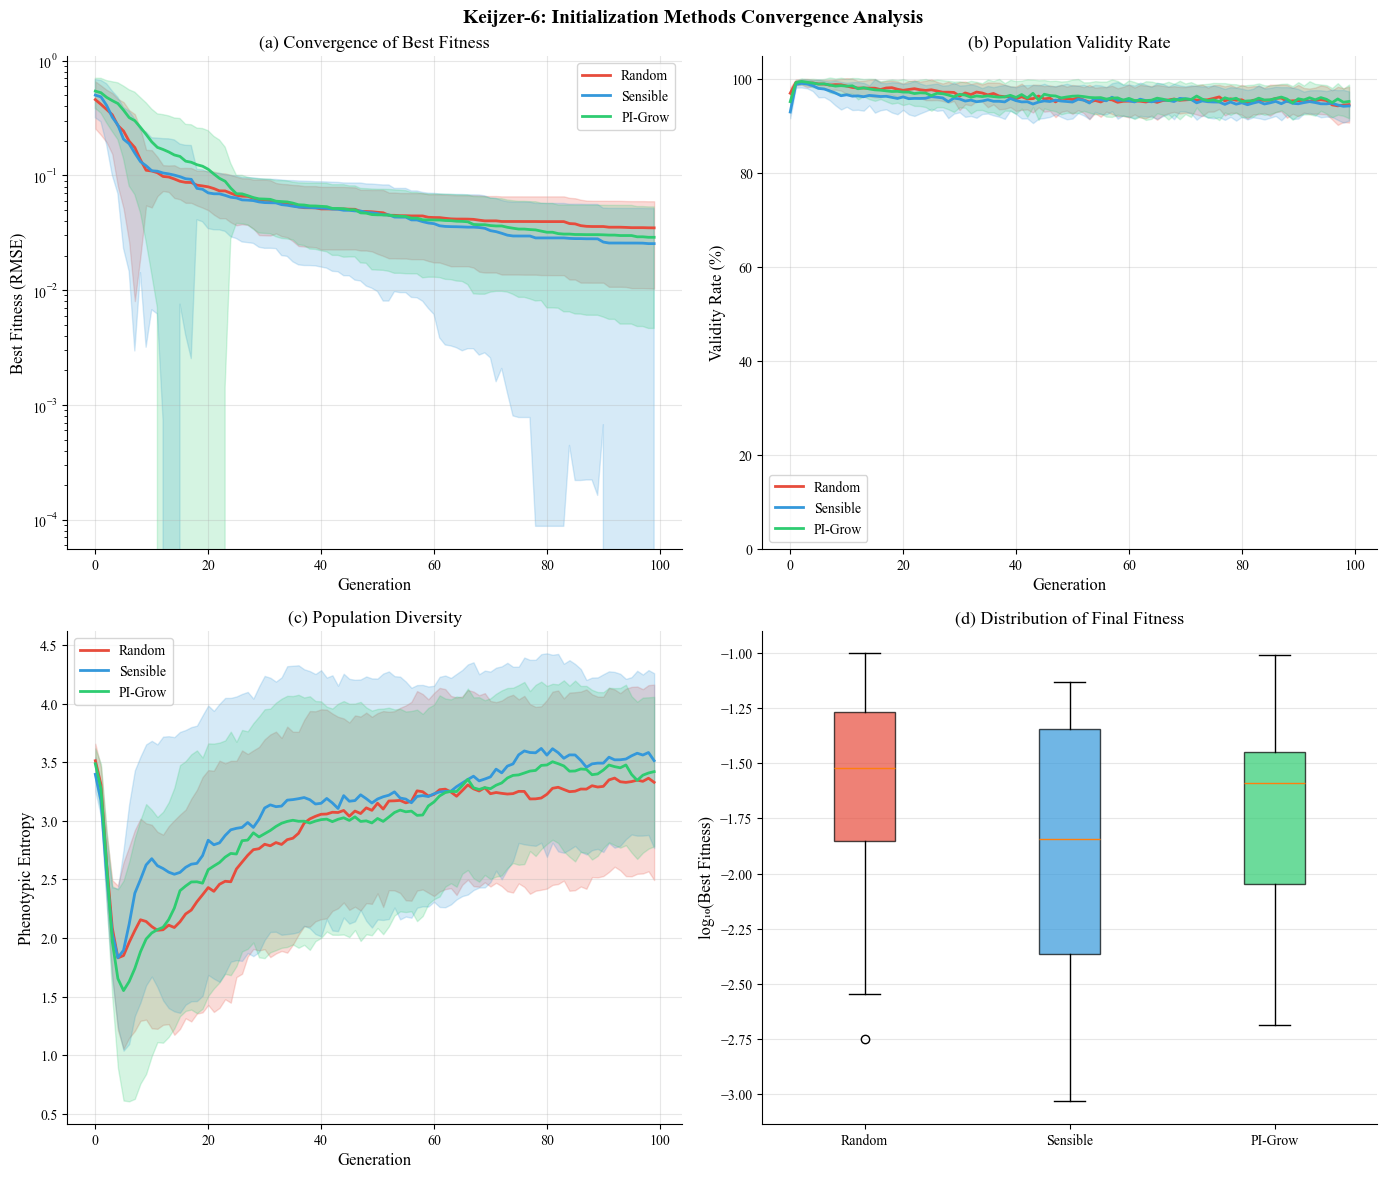

In [16]:
# %%
def plot_convergence(results):
    """ Plot convergence curves and statistics"""
    
    methods = list(results.keys())
    generations = len(results[methods[0]][0]['history']['best_fitness'])
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('Keijzer-6: Initialization Methods Convergence Analysis', 
                 fontsize=14, fontweight='bold')
    
    # (a) Best Fitness Convergence
    ax = axes[0, 0]
    for method in methods:
        curves = np.array([r['history']['best_fitness'] for r in results[method]])
        mean = np.mean(curves, axis=0)
        std = np.std(curves, axis=0)
        x = np.arange(generations)
        
        ax.plot(x, mean, label=method, color=COLORS[method], linewidth=2)
        ax.fill_between(x, mean - std, mean + std, color=COLORS[method], alpha=0.2)
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Best Fitness (RMSE)')
    ax.set_title('(a) Convergence of Best Fitness')
    ax.legend(frameon=True)
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    
    # (b) Validity Rate
    ax = axes[0, 1]
    for method in methods:
        curves = np.array([r['history']['validity_rate'] for r in results[method]])
        mean = np.mean(curves, axis=0) * 100
        std = np.std(curves, axis=0) * 100
        x = np.arange(generations)
        
        ax.plot(x, mean, label=method, color=COLORS[method], linewidth=2)
        ax.fill_between(x, mean - std, mean + std, color=COLORS[method], alpha=0.2)
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Validity Rate (%)')
    ax.set_title('(b) Population Validity Rate')
    ax.legend(frameon=True)
    ax.set_ylim([0, 105])
    ax.grid(True, alpha=0.3)
    
    # (c) Phenotypic Diversity
    ax = axes[1, 0]
    for method in methods:
        curves = np.array([r['history']['diversity'] for r in results[method]])
        mean = np.mean(curves, axis=0)
        std = np.std(curves, axis=0)
        x = np.arange(generations)
        
        ax.plot(x, mean, label=method, color=COLORS[method], linewidth=2)
        ax.fill_between(x, mean - std, mean + std, color=COLORS[method], alpha=0.2)
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Phenotypic Entropy')
    ax.set_title('(c) Population Diversity')
    ax.legend(frameon=True)
    ax.grid(True, alpha=0.3)
    
    # (d) Boxplot of Final Fitness
    ax = axes[1, 1]
    box_data = [np.log10([r['best_individual'].fitness for r in results[m]]) for m in methods]
    bp = ax.boxplot(box_data, labels=methods, patch_artist=True)
    
    for patch, method in zip(bp['boxes'], methods):
        patch.set_facecolor(COLORS[method])
        patch.set_alpha(0.7)
    
    ax.set_ylabel('log₁₀(Best Fitness)')
    ax.set_title('(d) Distribution of Final Fitness')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return fig


fig_convergence = plot_convergence(results)

###  Visualization 2: Best Solutions

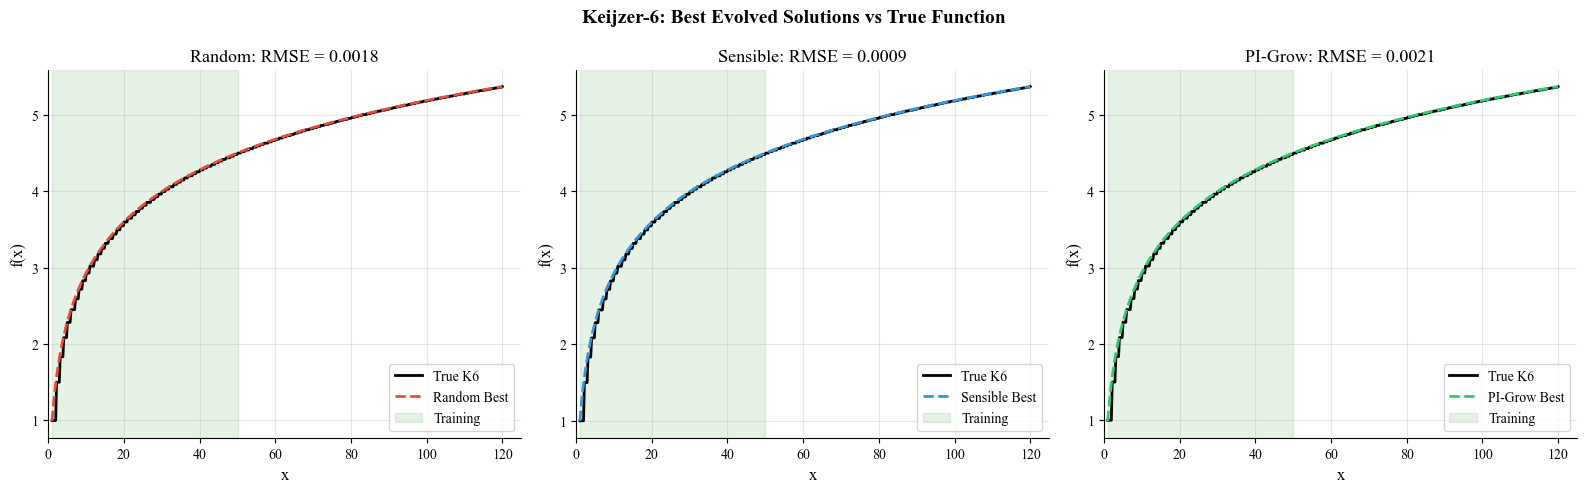

In [17]:
# 
# Comparing the best evolved solutions against the true Keijzer-6 function.

# %%
def plot_best_solutions(results, X_test, y_test):
    """ Plot best solutions vs true function"""
    
    methods = list(results.keys())
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Keijzer-6: Best Evolved Solutions vs True Function', 
                 fontsize=14, fontweight='bold')
    
    x_plot = np.linspace(1, 120, 500)
    y_true = keijzer_6(x_plot)
    
    for idx, method in enumerate(methods):
        ax = axes[idx]
        
        # Find best solution
        best_run = min(results[method], key=lambda r: r['best_individual'].fitness)
        best = best_run['best_individual']
        
        # Plot true function
        ax.plot(x_plot, y_true, 'k-', linewidth=2, label='True K6')
        
        # Plot prediction
        if best.valid and best.phenotype:
            try:
                pred = eval(best.phenotype, {'np': np, '__builtins__': {}}, {'x': x_plot})
                if np.isscalar(pred):
                    pred = np.full_like(x_plot, pred)
                pred = np.clip(pred, -100, 100)
                ax.plot(x_plot, pred, '--', color=COLORS[method], 
                       linewidth=2, label=f'{method} Best')
            except:
                pass
        
        # Training region
        ax.axvspan(1, 50, alpha=0.1, color='green', label='Training')
        
        ax.set_xlabel('x')
        ax.set_ylabel('f(x)')
        ax.set_title(f'{method}: RMSE = {best.fitness:.4f}')
        ax.legend(loc='lower right')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 125])
    
    plt.tight_layout()
    plt.show()
    
    return fig


fig_solutions = plot_best_solutions(results, X_test, y_test)

### Visualization 3: Initialization Analysis
### Comparing initial validity rates and fitness improvement.


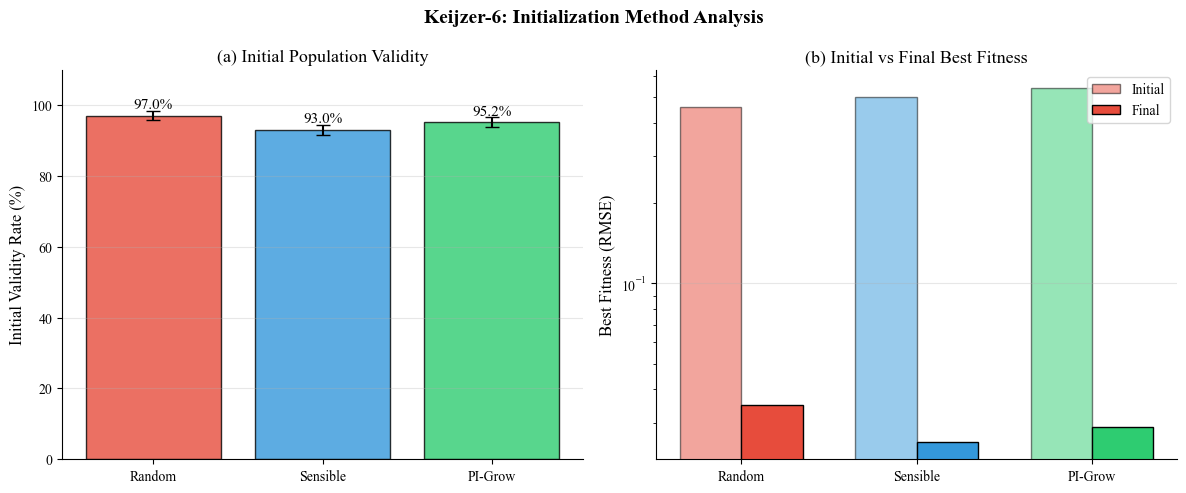

In [18]:

# %%
def plot_initialization_analysis(results):
    """ Plot initialization method comparison"""
    
    methods = list(results.keys())
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Keijzer-6: Initialization Method Analysis', 
                 fontsize=14, fontweight='bold')
    
    # (a) Initial Validity
    ax = axes[0]
    validity = {m: [r['history']['validity_rate'][0] * 100 for r in results[m]] for m in methods}
    
    means = [np.mean(validity[m]) for m in methods]
    stds = [np.std(validity[m]) for m in methods]
    
    bars = ax.bar(methods, means, yerr=stds, capsize=5,
                  color=[COLORS[m] for m in methods], alpha=0.8, edgecolor='black')
    
    for bar, mean in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{mean:.1f}%', ha='center', fontsize=11)
    
    ax.set_ylabel('Initial Validity Rate (%)')
    ax.set_title('(a) Initial Population Validity')
    ax.set_ylim([0, 110])
    ax.grid(True, alpha=0.3, axis='y')
    
    # (b) Initial vs Final Fitness
    ax = axes[1]
    
    init_fit = {m: [r['history']['best_fitness'][0] for r in results[m]] for m in methods}
    final_fit = {m: [r['best_individual'].fitness for r in results[m]] for m in methods}
    
    x = np.arange(len(methods))
    width = 0.35
    
    ax.bar(x - width/2, [np.mean(init_fit[m]) for m in methods], width, 
           label='Initial', color=[COLORS[m] for m in methods], alpha=0.5, edgecolor='black')
    ax.bar(x + width/2, [np.mean(final_fit[m]) for m in methods], width,
           label='Final', color=[COLORS[m] for m in methods], alpha=1.0, edgecolor='black')
    
    ax.set_xticks(x)
    ax.set_xticklabels(methods)
    ax.set_ylabel('Best Fitness (RMSE)')
    ax.set_title('(b) Initial vs Final Best Fitness')
    ax.legend()
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return fig


fig_init = plot_initialization_analysis(results)

### Best Solutions Found
### Displaying the best evolved solutions from each initialization method.

In [19]:

# %%
print("\n" + "=" * 70)
print(" BEST SOLUTIONS FOUND")
print("=" * 70)

for method in results:
    best_run = min(results[method], key=lambda r: r['best_individual'].fitness)
    best = best_run['best_individual']
    
    print(f"\n{'─' * 50}")
    print(f" {method} Initialization")
    print(f"{'─' * 50}")
    print(f"   Train RMSE: {best.fitness:.6f}")
    print(f"   Test RMSE:  {best_run['test_rmse']:.6f}")
    print(f"   Phenotype:  {best.phenotype}")




 BEST SOLUTIONS FOUND

──────────────────────────────────────────────────
 Random Initialization
──────────────────────────────────────────────────
   Train RMSE: 0.001775
   Test RMSE:  0.001412
   Phenotype:  np.log(((np.cos(np.log((np.sin(np.e)+0.1)))*x)+(x+np.cos(np.sin(np.e)))))

──────────────────────────────────────────────────
 Sensible Initialization
──────────────────────────────────────────────────
   Train RMSE: 0.000925
   Test RMSE:  0.000798
   Phenotype:  np.log(((np.cos(np.log(np.log(2.0)))+x)+(x*np.cos(np.sin(np.sin(np.log(0.1)))))))

──────────────────────────────────────────────────
 PI-Grow Initialization
──────────────────────────────────────────────────
   Train RMSE: 0.002063
   Test RMSE:  0.001699
   Phenotype:  np.log(((x+np.sin(2.0))+(1.0*(x*np.sin((1.0-0.1))))))
